In [1]:
import dotenv

dotenv.load_dotenv()

True

In [2]:
from tcav_classifier import EmbeddingDataset
from tcav_classifier import LinearClassifier



In [9]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
print("usetex?", mpl.rcParams['text.usetex'])  # should be False


usetex? False


In [4]:
project_names = [
    "gender_female",
    "gender_male",
    "language_de",
    "language_en",
    "language_es",
    "language_fr",
    "language_it",
    "language_ja",
    "language_pt",
]
encoder_ids = [
    "mert_v1_95m",
    "whisper_large_v2",
    "muq_large_msd",
    "muq_mulan_large",
]
target_column = "genre"

In [5]:
import json
import os
from typing import Literal

import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
from cavmir.evaluation import calculate_tcav_score
from cavmir.utils import load_df_and_embeddings, get_cav_vectors
import torch


s3 = s3fs.S3FileSystem()

trainings_prefix = os.environ["TRAININGS_PREFIX"]
dataset_prefix = os.environ["DATASET_PREFIX"]
embedding_prefix = os.environ["EMBEDDING_PREFIX"]
audio_prefix = os.environ["AUDIO_PREFIX"]


In [6]:
def get_train_evaluation_metrics(
    project_name, encoder_id, train_type: Literal["ttest", "full"] = "full"
):
    metrics_dir = os.path.join(
        trainings_prefix,
        "trainings",
        encoder_id,
        project_name,
        f"evaluation_metrics_{train_type}_{project_name}.json",
    )
    metrics = json.load(open(metrics_dir))
    return metrics


plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["FreeSans"],
        "font.serif": ["FreeSerif"],
        "axes.titlesize": 11,
        "axes.labelsize": 11,
        "xtick.labelsize": 8,
        "ytick.labelsize": 11,
        "legend.fontsize": 10,
        "text.usetex": True,
    }
)

project_name_display_map = {
    "gender_female": "Sex - Female",
    "gender_male": "Sex - Male",
    "language_de": "Language - German",
    "language_en": "Language - English",
    "language_es": "Language - Spanish",
    "language_fr": "Language - French",
    "language_it": "Language - Italian",
    "language_ja": "Language - Japanese",
    "language_pt": "Language - Portuguese",
    "r&b": "R\\&B",
    "metal": "Metal*",
    "blues": "Blues*",
    "reggae": "Reggae*",
    "christian": "Christian*",
    "classical": "Classical*",
}

### Measure Model Bias Using TCAV


In [7]:
from collections import defaultdict

from matplotlib import gridspec
from matplotlib.legend_handler import HandlerBase
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle
from scipy.stats import ttest_1samp


def calculate_tcav_scores(
    cav_weights: np.ndarray,
    cav_biases: np.ndarray,
    df: pd.DataFrame,
    target_column: str,
) -> dict[str, list[float]]:
    """
    Calculates the TCAV scores for each target label in the dataset.

    """
    target_labels = df[target_column].unique()

    tcav_scores = defaultdict(list)
    for target_label in target_labels:
        df_subset = df[df[target_column] == target_label]
        target_embeddings = np.array([np.array(x) for x in df_subset.embedding.values])
        for i, cav_weight in enumerate(cav_weights):
            tcav_scores[target_label].append(
                calculate_tcav_score(cav_weight, cav_biases[i], target_embeddings)
            )

    return tcav_scores

def calculate_tcav_gradient_scores(
    model: torch.nn.Module,
    cav_weights: np.ndarray,
    df: pd.DataFrame,
    label_encoder,
    target_column: str,
    embedding_col: str = "embedding",
    device: str = "cpu"
) -> dict[str, list[float]]:
    """
    Computes gradient-based TCAV scores using directional derivatives for each target label.

    Arguments:
        model: trained classifier (e.g., genre classifier)
        cav_weights: array of concept vectors (shape: [num_concepts, embedding_dim])
        df: dataframe with test embeddings and labels
        label_encoder: encoder used to map target labels (e.g., genre) to indices
        target_column: name of the column in df with labels
        embedding_col: column name of the embedding
        device: "cpu" or "cuda"

    Returns:
        Dictionary of TCAV scores for each target label
    """

    model.eval()
    model.to(device)
    cav_weights_tensor = torch.tensor(cav_weights, dtype=torch.float32, device=device)

    tcav_scores = defaultdict(list)
    target_labels = df[target_column].unique()

    for target_label in target_labels:
        ## cav orientation check includes comparison between male and female cavs 06.05##
                    
        label_idx = label_encoder.transform([target_label])[0]
        df_subset = df[df[target_column] == target_label]
        embeddings = np.stack(df_subset[embedding_col].values)

        if len(embeddings) == 0:
            continue

        embeddings_tensor = torch.tensor(
            embeddings,
            dtype=torch.float32,
            requires_grad=True,
            device=device
        )

        B, D = embeddings_tensor.shape
        assert cav_weights_tensor.shape[1] == D, "CAV dim ≠ embedding dim!"

        # ---- forward pass --------------------------------------------------
        logits = model(embeddings_tensor)                 # [N, num_classes]
        probs  = torch.softmax(logits, dim=1)             # convert to probabilities
        class_probs = probs[:, label_idx]                 # [N]  P(y = class | x)

        # ---- gradient of probability wrt embedding -------------------------
        gradients = torch.autograd.grad(
            outputs=class_probs,
            inputs=embeddings_tensor,
            grad_outputs=torch.ones_like(class_probs),
            only_inputs=True,
            retain_graph=False,
            create_graph=False
        )[0]                                              # [N, emb_dim]

        # ---- directional derivative & TCAV score ---------------------------
        for cav in cav_weights_tensor:                    # loop over every CAV
            dot = torch.sum(gradients * cav, dim=1)       # [N]  directional deriv
            tcav_score = (dot > 0).float().mean().item()  # fraction positive
            
            tcav_scores[target_label].append(tcav_score)

    return tcav_scores


def t_test_on_tcav_scores(
    tcav_scores: dict[str, list[float]],
    target_p_value: float = 0.05,
    bonferroni_correction: bool = True,
    verbose: bool = True,
) -> dict[str, dict[str, float | list[float] | bool]]:
    """
    Performs a t-test on the TCAV scores of each trained cav vector per target label.
    The null hypothesis is that the TCAV scores do not diverge from 0.5 (no bias).

    Parameters
    ----------
    tcav_scores : dict[str, list[float]]
        The TCAV scores per target label. Since we train mulitple cav vectors per target label, we expect a list of scores.
    target_p_value : float, optional
        The p-value threshold for the t-test, by default 0.05
    bonferroni_correction : bool, optional
        Whether to perform the Bonferroni correction on the p-values, by default True

    Returns
    -------
    pvalues : list[float]
        The p-values of the t-test for each target label.
    target_p_value : float
        The target p-value used for the t-test.
    """

    if bonferroni_correction:
        target_p_value_str = (
            f"({target_p_value} / {len(tcav_scores)}) (Bonferroni corrected)"
        )
        target_p_value = target_p_value / len(tcav_scores)
    else:
        target_p_value_str = f"{target_p_value}"

    results = defaultdict(dict)
    for label, scores in tcav_scores.items():
        ttest_result = ttest_1samp(scores, 0.5)

        p_value = ttest_result.pvalue
        statistic = ttest_result.statistic

        results[label]["t_statistic"] = statistic.tolist()
        results[label]["p_value"] = p_value.tolist()
        results[label]["confidence_interval"] = [
            *ttest_result.confidence_interval(confidence_level=1 - target_p_value)
        ]
        results[label]["significant"] = p_value < target_p_value

        if not verbose:
            continue

        print(
            f"\nPerforming t-test on TCAV scores for label: {label}\nt-statistic: {statistic:.4f}"
        )

        if p_value < target_p_value:
            print(f"p-value: {p_value:.4e} < {target_p_value_str}")
            print("The null hypothesis (popmean=0.5) can be rejected.")
        else:
            print(f"p-value: {p_value:.4e} >= {target_p_value_str}")
            print("The null hypothesis (popmean=0.5) cannot be rejected.")

    return results


# for multi colored ci interval legend
class MultiColorLegend:
    def __init__(self, colors):
        self._colors = colors


class MultiColorPatchHandler(HandlerBase):
    def create_artists(
        self,
        legend,
        orig_handle,
        xdescent,
        ydescent,
        width,
        height,
        fontsize,
        trans,
    ):
        patches = []
        n = len(orig_handle._colors)
        for i, color in enumerate(orig_handle._colors):
            p = Rectangle(
                (xdescent + i * width / n, ydescent),
                width / n,
                height,
                facecolor=color,
                edgecolor="black",
                transform=trans,
                linewidth=0.3,
            )
            patches.append(p)
        return patches


# for violin legend
class HandlerPatchWithLine(HandlerBase):
    def create_artists(
        self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans
    ):
        facecolor = orig_handle.get_facecolor()
        edgecolor = orig_handle.get_edgecolor()
        alpha = orig_handle.get_alpha()

        patch = Rectangle(
            [xdescent, ydescent],
            width,
            height,
            facecolor=facecolor,
            edgecolor=edgecolor,
            linewidth=1,
            alpha=alpha,
            transform=trans,
        )

        line = Line2D(
            [xdescent, xdescent + width],
            [ydescent + height / 2] * 2,
            linestyle="--",
            color="gray",
            linewidth=1,
            transform=trans,
        )

        return [patch, line]


def plot_tcav_scores(
    results: dict,
    project_name: str,
    out_file_name: str | None = None,
    ci_boxplot: bool = False,
):
    """
    Creates a relative bar plot of the TCAV scores for each target label.
    """

    def humaize_label(label):
        if label in project_name_display_map:
            return project_name_display_map[label]

        label = label.replace("_", " ")
        label = " ".join([x.capitalize() for x in label.split(" ")])
        return label

    colors = {
        "neutral": "#999999",
        "positive": "#56B4E9",
        "negative": "#E69F00",
    }

    encoders = [*results.keys()]
    n_encoders = len(results)

    sorted_labels = [
        *dict(
            sorted(
                results[encoders[0]]["tcav_scores"].items(),
                key=lambda x: np.mean(x[1]),
                reverse=False,
            )
        ).keys()
    ]

    fig = plt.figure(figsize=(12, 3))
    gs = gridspec.GridSpec(1, n_encoders, width_ratios=[1, 1, 1, 1], wspace=0)

    axes = [fig.add_subplot(gs[i]) for i in range(n_encoders)]

    for i, (encoder, ax) in enumerate(zip(encoders, axes)):
        sorted_data = [
            results[encoder]["tcav_scores"][label] for label in sorted_labels
        ]

        ### PLOT CI BOXES ####

        stats = []
        for label in sorted_labels:
            scores = results[encoder]["tcav_scores"][label]
            ci = results[encoder]["ttest_results"][label]["confidence_interval"]
            median = np.median(scores)
            mean = np.mean(scores)

            stats.append(
                {
                    "label": label,
                    "med": results[encoder]["tcav_scores_full"][label][0],
                    "mean": mean,
                    "q1": ci[0],
                    "q3": ci[1],
                    "whislo": ci[0],
                    "whishi": ci[1],
                    "fliers": scores,
                }
            )

        bplot = ax.bxp(
            stats,
            orientation="horizontal",
            showmeans=True,
            meanprops=dict(
                marker="D",
                markeredgecolor="black",
                markerfacecolor="firebrick",
                markersize=2,
                alpha=0.0,
            ),
            boxprops=dict(linewidth=0.5, alpha=1, zorder=3),
            whiskerprops=dict(linewidth=0.5, alpha=0),
            capprops=dict(linewidth=0.5, alpha=0),
            medianprops=dict(linewidth=1.0, alpha=0, color="firebrick", zorder=4),
            flierprops=dict(
                marker="o", color="black", alpha=0.00, markersize=2, zorder=1
            ),
            patch_artist=True,
        )

        box_colors = [
            colors["neutral"]
            if not results[encoder]["ttest_results"][label]["significant"]
            else colors["positive"]
            if np.mean(scores) > 0.5
            else colors["negative"]
            for label, scores in zip(sorted_labels, sorted_data)
        ]

        for patch, color in zip(bplot["boxes"], box_colors):
            patch.set_facecolor(color)

        #### PLOT VIOLIN PLOT ####

        violin_parts = ax.violinplot(
            sorted_data,
            orientation="horizontal",
            showmeans=True,
            showmedians=False,
            showextrema=False,
            widths=0.5,
            points=500,
        )
        for vp in violin_parts["bodies"]:
            vp.set_facecolor(colors["neutral"])
            vp.set_edgecolor(colors["neutral"])

        #### FORMAT PLOT ####

        ax.axvline(0.5, color="black", linewidth=0.5)

        if i == 0:
            ax.set_yticks(range(1, len(sorted_labels) + 1))
            ax.set_yticklabels([humaize_label(x) for x in sorted_labels])
        else:
            ax.set_yticks(range(1, len(sorted_labels) + 1))
            ax.set_yticklabels([])

        ax.set_xticks(np.arange(0, 1.1, 0.25))
        ax.set_xlim(-0.05, 1.05)

        ax.grid(axis="both", linestyle="--", linewidth=0.5)

        if i == n_encoders - 1:
            combined_ci_legend = MultiColorLegend(
                [colors["negative"], colors["neutral"], colors["positive"]]
            )

            violin_legend = Patch(
                facecolor=colors["neutral"],
                edgecolor=colors["neutral"],
                alpha=0.4,
            )

            # Add to legend
            legend_elements = [
                combined_ci_legend,
                violin_legend,
            ]

            plt.legend(
                handles=legend_elements,
                labels=["95\\% CI", "TCAV dist."],
                handler_map={
                    MultiColorLegend: MultiColorPatchHandler(),
                    Patch: HandlerPatchWithLine(),
                },
                loc="lower right",
                fontsize="x-small",
            )

        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)

        test_acc = results[encoder]["metrics_ttest_mean_acc"]
        ax.set_title(
            f"{encoder} (Ø Test Acc: {test_acc:.2f})",
            fontsize=12,
            pad=10,
            loc="left",
        )

    fig.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.05, left=0.05, right=0.98, wspace=0)

    if out_file_name:
        fig.savefig(out_file_name, dpi=300, bbox_inches="tight")

    plt.show()


[gender_female]  evaluating encoder: mert_v1_95m

┌─ Training‑set size for genre classifier for TCAV per genre ───────────────────────────────
pop                      : 4616
alternative              : 1046
electronic               : 744
brazilian_music          : 518
rock                     : 492
hip_hop                  : 418
r&b                      : 364
latin_american_music     : 288
french_music             : 230
asian_music              : 220
jazz                     : 206
soundtrack               : 100
christian                : 86
country                  : 84
reggae                   : 82
metal                    : 72
blues                    : 66
folk                     : 62
soul                     : 52
classical                : 52
└───────────────────────────────────────────────────────────────

Epoch 1/20, Loss: 2.0135
Epoch 2/20, Loss: 1.8343
Epoch 3/20, Loss: 1.7550
Epoch 4/20, Loss: 1.6990
Epoch 5/20, Loss: 1.6591
Epoch 6/20, Loss: 1.6294
Epoch 7/20, Loss: 1.6034
Ep

C:\Users\Eylul\cav-mir\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': -15.992781365551094, 'p_value': 8.860365831202224e-47, 'confidence_interval': [np.float64(0.2299241444727402), np.float64(0.31617031072122087)], 'significant': np.True_}, 'french_music': {'t_statistic': 2.0255966756528077, 'p_value': 0.04333782673864835, 'confidence_interval': [np.float64(0.48117123067498324), np.float64(0.5941157215393323)], 'significant': np.False_}, 'country': {'t_statistic': -24.048356280675524, 'p_value': 1.9622168535669477e-85, 'confidence_interval': [np.float64(0.11180774075105898), np.float64(0.19890654478281622)], 'significant': np.True_}, 'soundtrack': {'t_statistic': 50.944716629747596, 'p_value': 7.399609391952173e-200, 'confidence_interval': [np.float64(0.8993296966588469), np.float64(0.9499903188684611)], 'significant': np.True_}, 'hip_hop': {'t_statistic': -25.717420829751717, 'p_value': 1.7056365369541798e-93, 'confidence_interval': [np.float64(0.10708174564800262), np.float64

findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sa

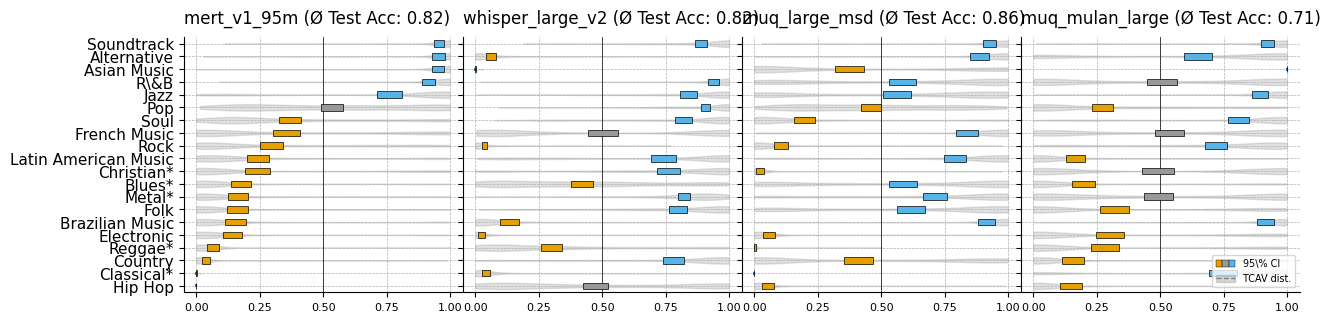

[gender_male]  evaluating encoder: mert_v1_95m
re‑using cached genre‑classifier for encoder: mert_v1_95m
ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': -3.2154614294199324, 'p_value': 0.0013867715248617267, 'confidence_interval': [np.float64(0.40006249789450893), np.float64(0.4971766708088143)], 'significant': np.True_}, 'french_music': {'t_statistic': 15.76395973940677, 'p_value': 9.996092525063971e-46, 'confidence_interval': [np.float64(0.7112072136322047), np.float64(0.8120797410389398)], 'significant': np.True_}, 'country': {'t_statistic': 41.11199957927102, 'p_value': 2.4189794891576377e-162, 'confidence_interval': [np.float64(0.8905655282778855), np.float64(0.9529106586085443)], 'significant': np.True_}, 'soundtrack': {'t_statistic': -58.67238357127199, 'p_value': 4.384178616469721e-226, 'confidence_interval': [np.float64(0.030290627561462488), np.float64(0.07654937238995972)], 'significant': np.True_}, 'hip_hop': {'t_statistic': 37205.27126022378, 

findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sa

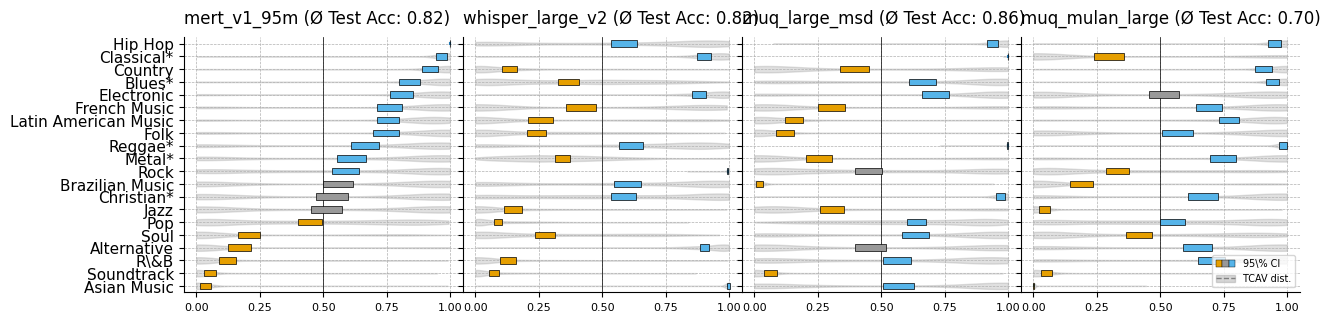

[language_de]  evaluating encoder: mert_v1_95m
re‑using cached genre‑classifier for encoder: mert_v1_95m
ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': 33.915814580220626, 'p_value': 1.2345667807718522e-131, 'confidence_interval': [np.float64(0.824901018450482), np.float64(0.8785301094441876)], 'significant': np.True_}, 'hip_hop': {'t_statistic': 5.2428721233396445, 'p_value': 2.3388269252664935e-07, 'confidence_interval': [np.float64(0.5523399353052587), np.float64(0.654205520686963)], 'significant': np.True_}, 'rock': {'t_statistic': -22.747344502892737, 'p_value': 4.050061020169421e-79, 'confidence_interval': [np.float64(0.14537527526882987), np.float64(0.2177675833817055)], 'significant': np.True_}, 'electronic': {'t_statistic': 13.105237778328389, 'p_value': 6.246873849208137e-34, 'confidence_interval': [np.float64(0.6903459444280711), np.float64(0.7839207215968522)], 'significant': np.True_}, 'classical': {'t_statistic': -13.45313438067927, 'p_value

findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sa

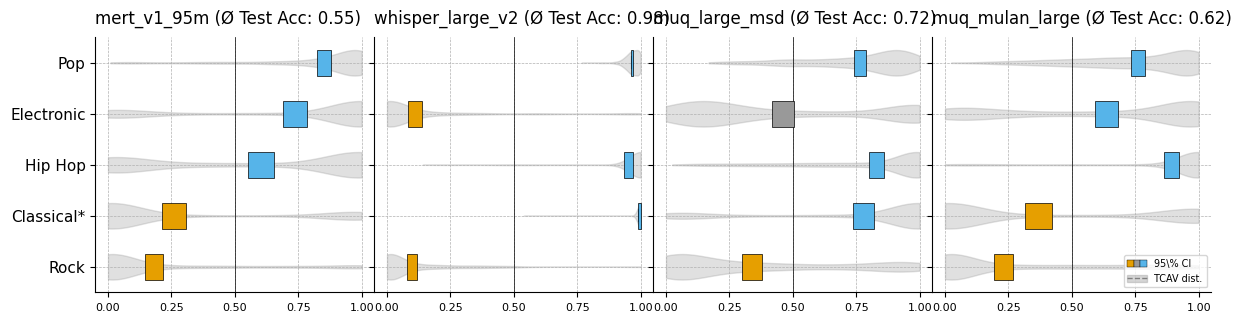

[language_en]  evaluating encoder: mert_v1_95m
re‑using cached genre‑classifier for encoder: mert_v1_95m
ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': -28.29096692782896, 'p_value': 9.044041469115058e-106, 'confidence_interval': [np.float64(0.22319199386101862), np.float64(0.27473108237804666)], 'significant': np.True_}, 'soundtrack': {'t_statistic': -41.77302080119818, 'p_value': 5.053992879409514e-165, 'confidence_interval': [np.float64(0.07112192742710777), np.float64(0.12687807374263338)], 'significant': np.True_}, 'hip_hop': {'t_statistic': 2.37956129275699, 'p_value': 0.017708153749105362, 'confidence_interval': [np.float64(0.4900873308165507), np.float64(0.5998469014385439)], 'significant': np.False_}, 'asian_music': {'t_statistic': -229.46828145183963, 'p_value': 0.0, 'confidence_interval': [np.float64(-0.0016986451714205916), np.float64(0.010841502335565108)], 'significant': np.True_}, 'rock': {'t_statistic': 5.8126980932954755, 'p_value': 1.097

C:\Users\Eylul\cav-mir\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': -193.48532619490913, 'p_value': 0.0, 'confidence_interval': [np.float64(0.16363911534531944), np.float64(0.17358701977447638)], 'significant': np.True_}, 'soundtrack': {'t_statistic': 172.85147062808872, 'p_value': 0.0, 'confidence_interval': [np.float64(0.9139266805333378), np.float64(0.9280733197050807)], 'significant': np.True_}, 'hip_hop': {'t_statistic': -4.8151692453329815, 'p_value': 1.953025046076543e-06, 'confidence_interval': [np.float64(0.4351148351122591), np.float64(0.4839364868189242)], 'significant': np.True_}, 'asian_music': {'t_statistic': -614.5948207551702, 'p_value': 0.0, 'confidence_interval': [np.float64(0.0009386121074120412), np.float64(0.005632816698177634)], 'significant': np.True_}, 'rock': {'t_statistic': 56.21140747689548, 'p_value': 5.125825004645092e-218, 'confidence_interval': [np.float64(0.7038015770131619), np.float64(0.726007314402434)], 'significant': np.True_}, 'jazz': {'t

C:\Users\Eylul\cav-mir\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': -111.97514212909667, 'p_value': 0.0, 'confidence_interval': [np.float64(0.15583005664979888), np.float64(0.17323111124937107)], 'significant': np.True_}, 'soundtrack': {'t_statistic': 128.17718696459804, 'p_value': 0.0, 'confidence_interval': [np.float64(0.8598125599143672), np.float64(0.8764951262953115)], 'significant': np.True_}, 'hip_hop': {'t_statistic': 14.118517104312815, 'p_value': 2.542847502941726e-38, 'confidence_interval': [np.float64(0.5987363405080472), np.float64(0.649874521925863)], 'significant': np.True_}, 'asian_music': {'t_statistic': -inf, 'p_value': 0.0, 'confidence_interval': [np.float64(0.0), np.float64(0.0)], 'significant': np.True_}, 'rock': {'t_statistic': 47.18092108443018, 'p_value': 4.435856911116201e-186, 'confidence_interval': [np.float64(0.6700070087564642), np.float64(0.6923085475313013)], 'significant': np.True_}, 'jazz': {'t_statistic': 99.36021141391564, 'p_value': 0.0, 'c

findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sa

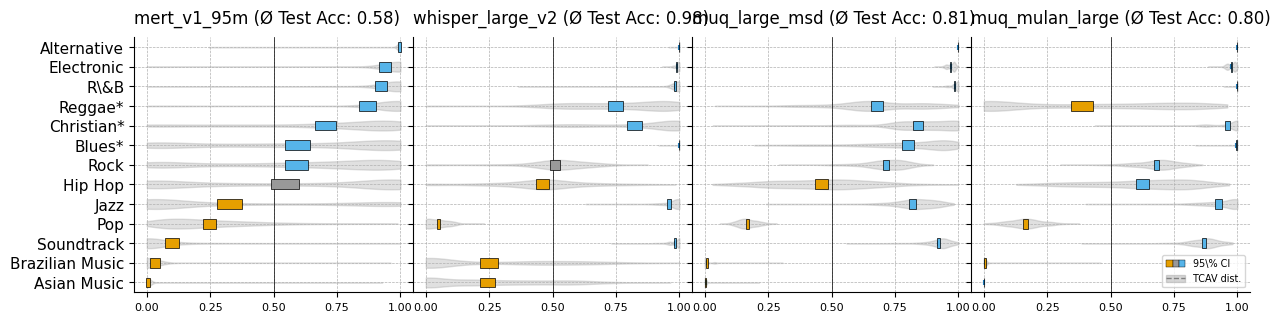

[language_es]  evaluating encoder: mert_v1_95m
re‑using cached genre‑classifier for encoder: mert_v1_95m
ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': -9.356888366025608, 'p_value': 2.7836422110348927e-19, 'confidence_interval': [np.float64(0.3421324561572551), np.float64(0.4104928957504303)], 'significant': np.True_}, 'hip_hop': {'t_statistic': 7.238760369913311, 'p_value': 1.7220352079101768e-12, 'confidence_interval': [np.float64(0.5880469156924607), np.float64(0.6859030851598856)], 'significant': np.True_}, 'rock': {'t_statistic': -35.0799627866314, 'p_value': 8.602764545485847e-137, 'confidence_interval': [np.float64(0.06750570392889677), np.float64(0.12688645241128507)], 'significant': np.True_}, 'electronic': {'t_statistic': -12.445660489578641, 'p_value': 3.711790541782667e-31, 'confidence_interval': [np.float64(0.24078438563741228), np.float64(0.32996561574094513)], 'significant': np.True_}, 'latin_american_music': {'t_statistic': 128.0510294117

C:\Users\Eylul\cav-mir\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': -24.189156099602645, 'p_value': 4.079540370310303e-86, 'confidence_interval': [np.float64(0.32035549869261176), np.float64(0.35505295179538937)], 'significant': np.True_}, 'hip_hop': {'t_statistic': -63.073073359460786, 'p_value': 6.727976766387773e-240, 'confidence_interval': [np.float64(0.07857896180807819), np.float64(0.11177103900552521)], 'significant': np.True_}, 'rock': {'t_statistic': -34.15043907175384, 'p_value': 1.1128821469548406e-132, 'confidence_interval': [np.float64(0.14275699347518528), np.float64(0.19304693345464624)], 'significant': np.True_}, 'electronic': {'t_statistic': 14.698532078673203, 'p_value': 6.764184480755918e-41, 'confidence_interval': [np.float64(0.6479572844736097), np.float64(0.7111260500990035)], 'significant': np.True_}, 'latin_american_music': {'t_statistic': inf, 'p_value': 0.0, 'confidence_interval': [np.float64(1.0), np.float64(1.0)], 'significant': np.True_}})
[langua

findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sa

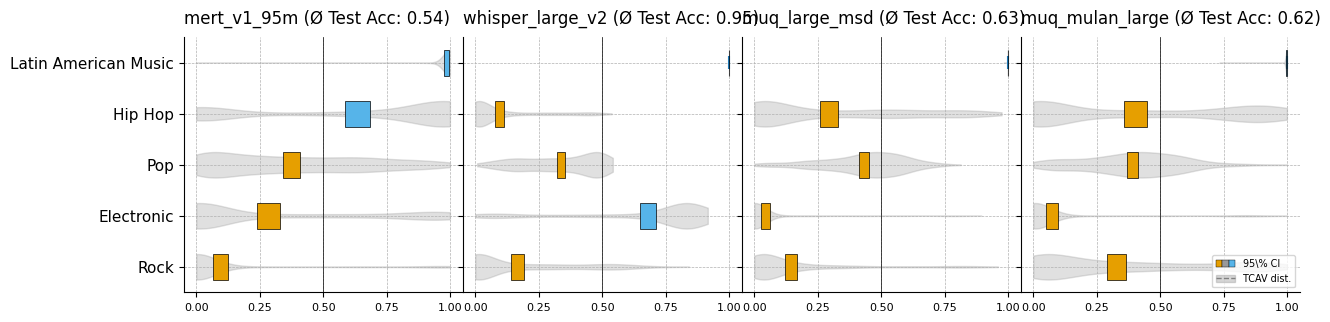

[language_fr]  evaluating encoder: mert_v1_95m
re‑using cached genre‑classifier for encoder: mert_v1_95m
ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': 25.029939236452787, 'p_value': 3.5058010401584133e-90, 'confidence_interval': [np.float64(0.7245190722693803), np.float64(0.7798536602544485)], 'significant': np.True_}, 'hip_hop': {'t_statistic': 14.32361324893823, 'p_value': 3.1590049032184445e-39, 'confidence_interval': [np.float64(0.7022882725239808), np.float64(0.7982476827128946)], 'significant': np.True_}, 'rock': {'t_statistic': -97.09296717194752, 'p_value': 0.0, 'confidence_interval': [np.float64(0.017913500984269717), np.float64(0.04443265355650747)], 'significant': np.True_}, 'jazz': {'t_statistic': 41.09790605910433, 'p_value': 2.7607592975329425e-162, 'confidence_interval': [np.float64(0.8948974189218921), np.float64(0.9514474079701262)], 'significant': np.True_}, 'r&b': {'t_statistic': 3.44725797033148, 'p_value': 0.0006141627674890014, 'con

findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sa

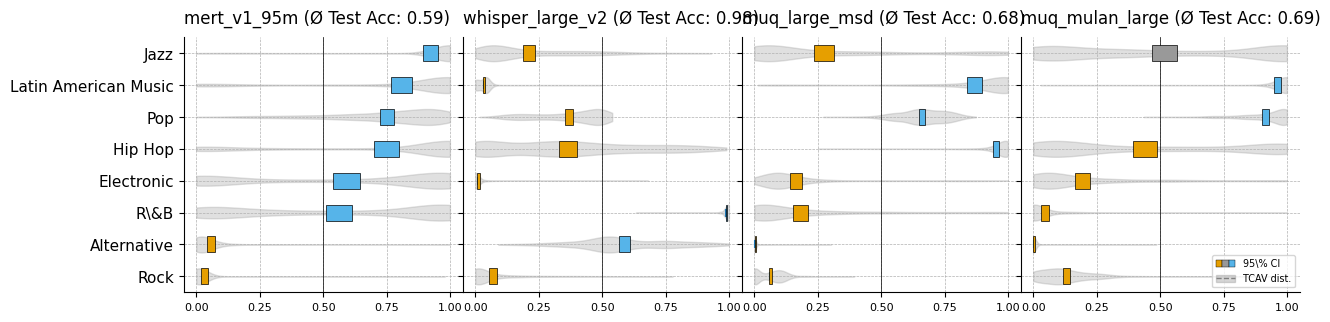

[language_it]  evaluating encoder: mert_v1_95m
re‑using cached genre‑classifier for encoder: mert_v1_95m
ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': 12.080592418861402, 'p_value': 1.1839307412702924e-29, 'confidence_interval': [np.float64(0.6366646546386181), np.float64(0.711099804967642)], 'significant': np.True_}, 'hip_hop': {'t_statistic': 0.9469181830410114, 'p_value': 0.3441387873312134, 'confidence_interval': [np.float64(0.4667664797437978), np.float64(0.5716389806138682)], 'significant': np.False_}, 'rock': {'t_statistic': 23.589704376236494, 'p_value': 3.2870700573726863e-83, 'confidence_interval': [np.float64(0.7897322151787901), np.float64(0.8610677880964851)], 'significant': np.True_}, 'latin_american_music': {'t_statistic': -4.543217015764286, 'p_value': 6.956521931049592e-06, 'confidence_interval': [np.float64(0.3648299668852687), np.float64(0.46288432131963964)], 'significant': np.True_}, 'classical': {'t_statistic': 2.315832992996516, 'p

C:\Users\Eylul\cav-mir\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': 567.260283016422, 'p_value': 0.0, 'confidence_interval': [np.float64(0.9778769381517507), np.float64(0.9822534584527873)], 'significant': np.True_}, 'hip_hop': {'t_statistic': 43.909981085671056, 'p_value': 1.5839641576229486e-173, 'confidence_interval': [np.float64(0.8619800266604444), np.float64(0.9072792324442843)], 'significant': np.True_}, 'rock': {'t_statistic': -65.28326160276245, 'p_value': 1.476327880384508e-246, 'confidence_interval': [np.float64(0.17327966203526698), np.float64(0.19817488115294732)], 'significant': np.True_}, 'latin_american_music': {'t_statistic': -743.1537036924299, 'p_value': 0.0, 'confidence_interval': [np.float64(0.0006973290613698424), np.float64(0.0041598139682007375)], 'significant': np.True_}, 'classical': {'t_statistic': inf, 'p_value': 0.0, 'confidence_interval': [np.float64(1.0), np.float64(1.0)], 'significant': np.True_}})
[language_it]  evaluating encoder: muq_large_m

findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sa

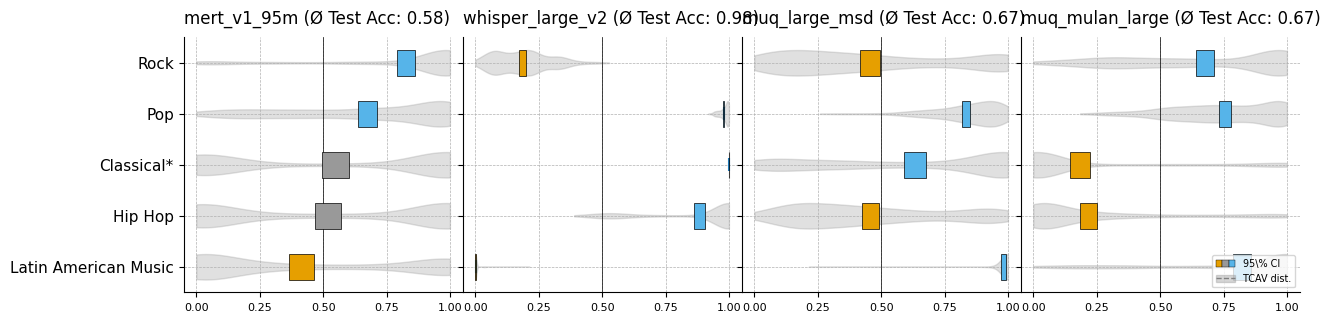

[language_ja]  evaluating encoder: mert_v1_95m
re‑using cached genre‑classifier for encoder: mert_v1_95m


C:\Users\Eylul\cav-mir\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': -22.77686481639034, 'p_value': 2.9108406940477845e-79, 'confidence_interval': [np.float64(0.277885731876354), np.float64(0.3231748731355264)], 'significant': np.True_}, 'asian_music': {'t_statistic': inf, 'p_value': 0.0, 'confidence_interval': [np.float64(1.0), np.float64(1.0)], 'significant': np.True_}, 'rock': {'t_statistic': 141.7085691303995, 'p_value': 0.0, 'confidence_interval': [np.float64(0.9572323329979449), np.float64(0.9742284442251654)], 'significant': np.True_}, 'electronic': {'t_statistic': -54.013449478041196, 'p_value': 1.3671929900200572e-210, 'confidence_interval': [np.float64(0.04781576982203788), np.float64(0.08913159896370104)], 'significant': np.True_}, 'reggae': {'t_statistic': -0.3489631393294393, 'p_value': 0.7272641805552174, 'confidence_interval': [np.float64(0.4463880618479906), np.float64(0.5408619381520093)], 'significant': np.False_}})
[language_ja]  evaluating encoder: whisper_

C:\Users\Eylul\cav-mir\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': -34.3248431826401, 'p_value': 1.8684705973777778e-133, 'confidence_interval': [np.float64(0.291789075143667), np.float64(0.3209609250202458)], 'significant': np.True_}, 'asian_music': {'t_statistic': inf, 'p_value': 0.0, 'confidence_interval': [np.float64(1.0), np.float64(1.0)], 'significant': np.True_}, 'rock': {'t_statistic': 7.420785025706162, 'p_value': 5.053185891143196e-13, 'confidence_interval': [np.float64(0.5285822905274677), np.float64(0.5591530060124945)], 'significant': np.True_}, 'electronic': {'t_statistic': 77.65790888635206, 'p_value': 8.496607020135329e-281, 'confidence_interval': [np.float64(0.848674774913766), np.float64(0.8726936430645207)], 'significant': np.True_}, 'reggae': {'t_statistic': 57.50013533620102, 'p_value': 2.83857897908555e-222, 'confidence_interval': [np.float64(0.7803613180739025), np.float64(0.8067636819260974)], 'significant': np.True_}})
[language_ja]  evaluating encod

C:\Users\Eylul\cav-mir\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': -45.39512874475964, 'p_value': 2.7021723167036304e-179, 'confidence_interval': [np.float64(0.24857558092026197), np.float64(0.2756744178429417)], 'significant': np.True_}, 'asian_music': {'t_statistic': inf, 'p_value': 0.0, 'confidence_interval': [np.float64(1.0), np.float64(1.0)], 'significant': np.True_}, 'rock': {'t_statistic': 16.17955767814785, 'p_value': 1.2159450942639928e-47, 'confidence_interval': [np.float64(0.5895663129932223), np.float64(0.6236395696156682)], 'significant': np.True_}, 'electronic': {'t_statistic': -15.86137470989042, 'p_value': 3.5678174193343076e-46, 'confidence_interval': [np.float64(0.25454161816752596), np.float64(0.32335312134110283)], 'significant': np.True_}, 'reggae': {'t_statistic': 37.65844430134077, 'p_value': 5.8985973605017845e-148, 'confidence_interval': [np.float64(0.8222428232245186), np.float64(0.8697571767754814)], 'significant': np.True_}})
[language_ja]  evalua

C:\Users\Eylul\cav-mir\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': -110.10591063132533, 'p_value': 0.0, 'confidence_interval': [np.float64(0.08598524978283985), np.float64(0.10498444744672435)], 'significant': np.True_}, 'asian_music': {'t_statistic': inf, 'p_value': 0.0, 'confidence_interval': [np.float64(1.0), np.float64(1.0)], 'significant': np.True_}, 'rock': {'t_statistic': 185.52754997226475, 'p_value': 0.0, 'confidence_interval': [np.float64(0.9146926170355038), np.float64(0.92641522874773)], 'significant': np.True_}, 'electronic': {'t_statistic': -41.92194721517063, 'p_value': 1.267898705398249e-165, 'confidence_interval': [np.float64(0.1160073491327892), np.float64(0.160624229834186)], 'significant': np.True_}, 'reggae': {'t_statistic': 13.446554103766424, 'p_value': 2.1543504328943468e-35, 'confidence_interval': [np.float64(0.6765843013862262), np.float64(0.7606656986137738)], 'significant': np.True_}})


findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sa

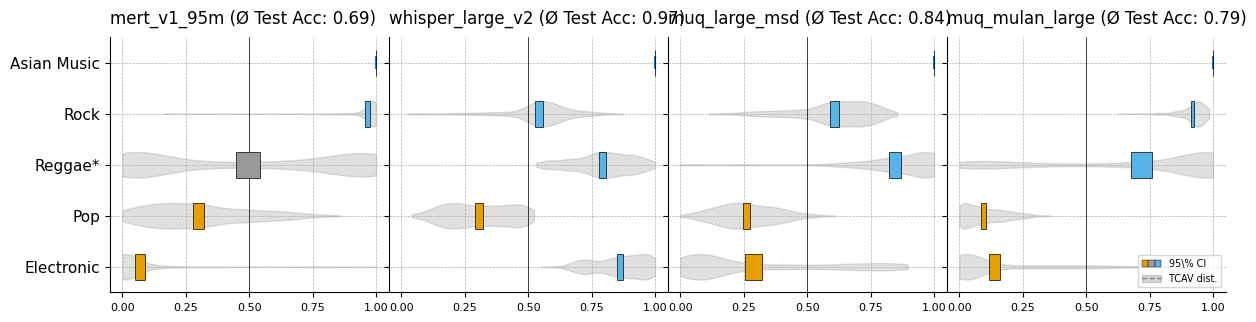

[language_pt]  evaluating encoder: mert_v1_95m
re‑using cached genre‑classifier for encoder: mert_v1_95m
ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': -28.453912236827055, 'p_value': 1.5384580803616195e-106, 'confidence_interval': [np.float64(0.16679797798092985), np.float64(0.2254507774349716)], 'significant': np.True_}, 'hip_hop': {'t_statistic': 7.679883370599177, 'p_value': 8.476130867217501e-14, 'confidence_interval': [np.float64(0.5921144013320865), np.float64(0.6946503004292187)], 'significant': np.True_}, 'rock': {'t_statistic': -10.552966644496742, 'p_value': 1.2295550885044069e-23, 'confidence_interval': [np.float64(0.2788809488832239), np.float64(0.37019597346268257)], 'significant': np.True_}, 'jazz': {'t_statistic': 14.502141550269373, 'p_value': 5.0908105668848415e-40, 'confidence_interval': [np.float64(0.6900966639047753), np.float64(0.7789033317813383)], 'significant': np.True_}, 'brazilian_music': {'t_statistic': 101.00886416497156, 'p_v

C:\Users\Eylul\cav-mir\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': -19406.93630569066, 'p_value': 0.0, 'confidence_interval': [np.float64(-1.6014497598277984e-05), np.float64(0.0001254672313682907)], 'significant': np.True_}, 'hip_hop': {'t_statistic': -16.80601789440516, 'p_value': 1.4806477545125709e-50, 'confidence_interval': [np.float64(0.3604609792796789), np.float64(0.3996566722126783)], 'significant': np.True_}, 'rock': {'t_statistic': -35.20257570167133, 'p_value': 2.486975489035441e-137, 'confidence_interval': [np.float64(0.27969971601155513), np.float64(0.31158234564351917)], 'significant': np.True_}, 'jazz': {'t_statistic': 843.7211027194877, 'p_value': 0.0, 'confidence_interval': [np.float64(0.7375139135130572), np.float64(0.7390650171033216)], 'significant': np.True_}, 'brazilian_music': {'t_statistic': inf, 'p_value': 0.0, 'confidence_interval': [np.float64(1.0), np.float64(1.0)], 'significant': np.True_}, 'blues': {'t_statistic': 82.3914076608773, 'p_value': 1

C:\Users\Eylul\cav-mir\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': -117.03397785539384, 'p_value': 0.0, 'confidence_interval': [np.float64(0.06815950260654603), np.float64(0.08795990021369836)], 'significant': np.True_}, 'hip_hop': {'t_statistic': -8.359025169011321, 'p_value': 6.334979666986499e-16, 'confidence_interval': [np.float64(0.3630461975373586), np.float64(0.4307773313112297)], 'significant': np.True_}, 'rock': {'t_statistic': -8.530557996251824, 'p_value': 1.7531841960501174e-16, 'confidence_interval': [np.float64(0.3540481577586943), np.float64(0.4251313359926825)], 'significant': np.True_}, 'jazz': {'t_statistic': 52.61526611307064, 'p_value': 9.380679918915974e-206, 'confidence_interval': [np.float64(0.7721210410659075), np.float64(0.8020894894386769)], 'significant': np.True_}, 'brazilian_music': {'t_statistic': inf, 'p_value': 0.0, 'confidence_interval': [np.float64(1.0), np.float64(1.0)], 'significant': np.True_}, 'blues': {'t_statistic': 59.44355373557594, 

C:\Users\Eylul\cav-mir\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


ttest result (gradients): defaultdict(<class 'dict'>, {'pop': {'t_statistic': -52.09153498535385, 'p_value': 6.411326032170458e-204, 'confidence_interval': [np.float64(0.19673939640539612), np.float64(0.22711134981271894)], 'significant': np.True_}, 'hip_hop': {'t_statistic': 2.7621861706377833, 'p_value': 0.005953385760694519, 'confidence_interval': [np.float64(0.5002056092662369), np.float64(0.5700885099726165)], 'significant': np.True_}, 'rock': {'t_statistic': -20.808941583154567, 'p_value': 1.0557345776790971e-69, 'confidence_interval': [np.float64(0.2483557405804725), np.float64(0.3070288847351937)], 'significant': np.True_}, 'jazz': {'t_statistic': 36.99269866530374, 'p_value': 4.156858739195561e-145, 'confidence_interval': [np.float64(0.733610344898255), np.float64(0.7710738647167371)], 'significant': np.True_}, 'brazilian_music': {'t_statistic': inf, 'p_value': 0.0, 'confidence_interval': [np.float64(1.0), np.float64(1.0)], 'significant': np.True_}, 'blues': {'t_statistic': 13

findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sans-serif' not found because none of the following families were found: FreeSans
findfont: Generic family 'sa

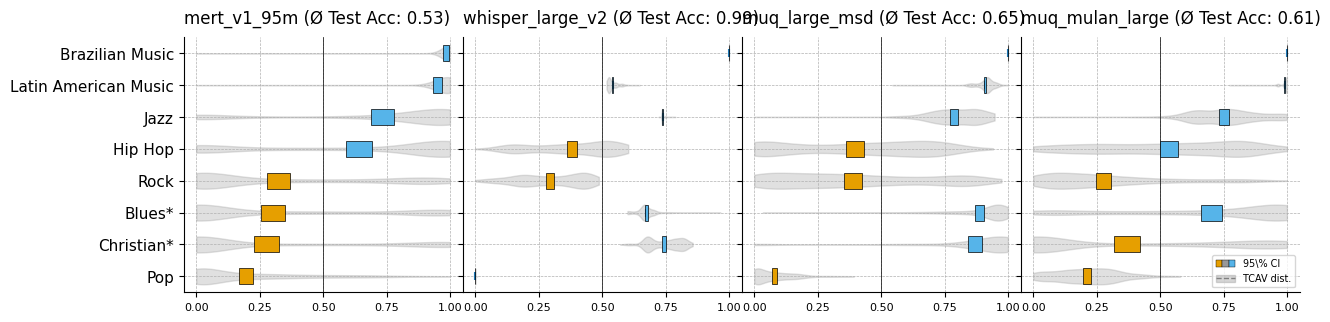

In [10]:
'''
ASK: folk, ?christian,  is in test but not train set for languages?: 'asian_music', 'country', 'brazilian_music', 'blues', 'metal', 'latin_american_music', 'soundtrack', 'r&b', 'alternative', 'christian', 'reggae', 'jazz', 'french_music', 'soul', 'folk'
Why do some genres show “nonsense” values?
Genres with 0.0 F1 (Soul, Soundtrack) still yield TCAV scores far from 0.5.
Reason: Even if the classifier is guessing the label, its gradient can still correlate with the CAV direction simply because the underlying encoder geometry happens to align that way.
Interpretation must therefore be cautious: a strong TCAV bias is only meaningful when the classifier actually understands the genre (i.e. non‑trivial F1).

Plotting – The yellow CI boxes and violin wings are drawn from the distribution of TCAV scores you get when you feed the ttest­ CAV bundle through the model. That visual reflects statistical uncertainty.
'''
#TODO: show the classifier that has high f1 scores
from sklearn.preprocessing import LabelEncoder
table_metrics      = {}

# ─── genre / language / gender classifier cache ──────────────────────────
classifier_cache: dict[tuple[str, str], LinearClassifier] = {}
labelenc_cache : dict[tuple[str, str], LabelEncoder]     = {}

for project_name in project_names:
    project_metrics = defaultdict(dict)

    for encoder_id in encoder_ids:
        cache_key = (encoder_id, target_column) 
        print(f"[{project_name}]  evaluating encoder: {encoder_id}")

        df_test = load_df_and_embeddings(
            project_name, "test",
            encoder_id, dataset_prefix, embedding_prefix, s3
        )

        if cache_key not in classifier_cache:
            model, dataset = LinearClassifier.train_classifier(
                df=df_test,                    # first time we see this encoder
                embedding_col="embedding",
                target_col=target_column,
                device="cpu")
            classifier_cache[cache_key] = model
            labelenc_cache[cache_key]  = dataset.label_encoder
            print(f"cached {target_column}‑classifier for encoder: {encoder_id}")
        else:
            model            = classifier_cache[cache_key]
            dataset_encoder  = labelenc_cache[cache_key]
            print(f"re‑using cached {target_column}‑classifier for encoder: {encoder_id}")

            '''
            missing = set(df_test[target_column]) - set(dataset_encoder.classes_)
            if missing:
                print(f"{missing=} unseen for cached classifier → skipping")
                continue
            missing_train = set(dataset_encoder.classes_) - set(df_test[target_column])
            if missing_train:
                print(f"{missing_train=} unseen in the training classifier")
                continue
            print(f"reusing cached classifier for encoder: {encoder_id}")
            '''

        # ----------------------- CAVs -------------------------------------
        cav_w_full  = get_cav_vectors(project_name, encoder_id, "weight_full")
        cav_w_ttest = get_cav_vectors(project_name, encoder_id, "weight_ttest")
        cav_b_full  = get_cav_vectors(project_name, encoder_id, "bias_full")
        cav_b_ttest = get_cav_vectors(project_name, encoder_id, "bias_ttest")

        
        tcav_scores_gradients = calculate_tcav_gradient_scores(
            model=model,
            cav_weights=cav_w_ttest.squeeze(1),
            df=df_test,
            label_encoder=dataset.label_encoder,
            target_column=target_column,
            embedding_col="embedding",
            device="cpu"
        )

        tcav_scores_gradients_full = calculate_tcav_gradient_scores(
            model=model,
            cav_weights=cav_w_full,
            df=df_test,
            label_encoder=dataset.label_encoder,
            target_column=target_column,
            embedding_col="embedding",
            device="cpu"
        )

        # --------------- projection‑only TCAV -----------------------------
        tcav_proj   = calculate_tcav_scores(cav_w_ttest, cav_b_ttest,
                                            df_test, target_column)
        tcav_proj_full = calculate_tcav_scores(cav_w_full, cav_b_full,
                                               df_test, target_column)

        # --------------- statistical tests --------------------------------
        ttest_result_gradients  = t_test_on_tcav_scores(tcav_scores_gradients,  verbose=False)
        print(f"ttest result (gradients): {ttest_result_gradients}")

        #----------------metrics-------------------------------------------
        project_metrics[encoder_id]["tcav_scores"] = tcav_scores_gradients
        project_metrics[encoder_id]["ttest_results"] = ttest_result_gradients

        project_metrics[encoder_id]["metrics_ttest"] = get_train_evaluation_metrics(
            project_name, encoder_id, "ttest"
        )
        mean_test_acc = np.mean(
            [x["accuracy"] for x in project_metrics[encoder_id]["metrics_ttest"]]
        )
        project_metrics[encoder_id]["metrics_ttest_mean_acc"] = mean_test_acc
        project_metrics[encoder_id]["tcav_scores_full"] = tcav_scores_gradients_full
        
    # ── plot once per PROJECT (all encoders) ───────────────────────────────
    out_png = os.path.join("plots",
                           f"tcav_ttest_{project_name}_{target_column}.png")
    plot_tcav_scores(project_metrics, project_name, out_file_name=out_png)
    table_metrics[project_name] = project_metrics


### Create Train Metrics Table


In [ ]:
import re
from collections import defaultdict


def format_table_models_with_metrics_columns(data):
    def escape_latex(s):
        if not isinstance(s, str):
            s = str(s)
        special_chars = {
            "&": r"\&",
            "%": r"\%",
            "$": r"\$",
            "#": r"\#",
            "_": r"\_",
            "{": r"\{",
            "}": r"\}",
            "~": r"\textasciitilde{}",
            "^": r"\textasciicircum{}",
            "\\": r"\textbackslash{}",
        }
        regex = re.compile("|".join(re.escape(key) for key in special_chars.keys()))
        return regex.sub(lambda match: special_chars[match.group()], s)

    models = list(data[project_names[0]].keys())

    metrics = {
        "Full Acc": ["metrics_full", "accuracy"],
        "Ø TTest Acc": ["metrics_ttest_mean_acc"],
    }

    # --- Header Rows ---
    header1 = ["\\textbf{}"] + [
        f"\\multicolumn{{{len(metrics)}}}{{c}}{{{escape_latex(m)}}}" for m in models
    ]
    header2 = [""] + [*metrics.keys()] * len(models)

    # --- Data Rows ---
    rows = []
    for pn in project_names:
        row = [project_name_display_map[pn]]
        for model in models:
            for metric_name in metrics:
                val = data[pn][model].copy()
                for locator in metrics[metric_name]:
                    val = val.get(locator)
                row.append(f"{val:.2f}")
        rows.append(row)

    num_cols = len(header2)
    col_format = "l" + " c" * (num_cols - 1)

    # --- LaTeX Table Code ---
    table = "\\begin{table}[ht]\n\\centering\n"
    table += "\\renewcommand{\\arraystretch}{1.}\n"
    table += "\\setlength{\\tabcolsep}{2pt} \n"
    table += "\\small\n"
    table += "\\begin{tabular}{" + col_format + "}\n"
    table += "\\toprule\n"
    table += " & ".join(header1) + " \\\\\n"
    table += " & ".join(header2) + " \\\\\n"
    table += "\\midrule\n"
    for row in rows:
        table += " & ".join(row) + " \\\\\n"
    table += "\\bottomrule\n"
    table += "\\end{tabular}\n"
    table += "\\caption{{Some Caption}}\n"
    table += "\\label{{some:label}}\n"
    table += "\\end{table}"

    # --- Full LaTeX Document ---
    document = (
        r"""\documentclass{article}
\usepackage[utf8]{inputenc}
\usepackage{geometry}
\geometry{margin=1in}
\usepackage{booktabs}
\usepackage{multirow}
\title{Some Table}
\begin{document}
\maketitle
"""
        + "\n"
        + table
        + "\n"
        + r"\end{document}"
    )

    return document


In [ ]:
table_metrics = {}

for project_name in project_names:
    project_metrics = defaultdict(dict)

    for encoder_id in encoder_ids:
        project_metrics[encoder_id]["metrics_ttest"] = get_train_evaluation_metrics(
            project_name, encoder_id, "ttest"
        )

        mean_test_acc = np.mean(
            [x["accuracy"] for x in project_metrics[encoder_id]["metrics_ttest"]]
        )
        project_metrics[encoder_id]["metrics_ttest_mean_acc"] = mean_test_acc
        project_metrics[encoder_id]["metrics_full"] = get_train_evaluation_metrics(
            project_name, encoder_id, "full"
        )

    table_metrics[project_name] = project_metrics

open("latex.tex", "w").write(format_table_models_with_metrics_columns(table_metrics))


In [ ]:
!pdflatex latex.tex 

### Concept De-biasing


In [ ]:
import os

import numpy as np
import pandas as pd
import s3fs
from cavmir.utils import load_df_and_embeddings, train_cav_classifier, get_cav_vectors
from collections import defaultdict
import matplotlib.pyplot as plt

s3 = s3fs.S3FileSystem()

embedding_prefix = os.environ["EMBEDDING_PREFIX"]
dataset_prefix = os.environ["DATASET_PREFIX"]


def equally_sample_from_df(
    df: pd.DataFrame, col: str, val: object, n: int, random_state: int
) -> pd.DataFrame:
    df_positive = df[df[col] == val]
    df_negative = df[df[col] != val]

    df_positive_sample = df_positive.sample(n=n // 2, random_state=random_state)
    df_negative_sample = df_negative.sample(n=n // 2, random_state=random_state)

    return pd.concat([df_positive_sample, df_negative_sample])


#### Train Hip-Hop Classifier


In [ ]:
project_name = "genre_hip_hop"
encoder_id = "muq_mulan_large"

epochs = 10000
learning_rate = 0.004
embedding_dim = 512
dropout = 0.0

In [ ]:
# remove last folder and replace by "dataset_hip_hop"
dataset_hip_hop_prefix = dataset_prefix.split("/")[:-2]
dataset_hip_hop_prefix.append("dataset_hip_hop")
dataset_hip_hop_prefix = "/".join(dataset_hip_hop_prefix)


In [ ]:
train_val_split = 0.9

df = load_df_and_embeddings(
    project_name,
    "train",
    encoder_id,
    dataset_hip_hop_prefix,
    embedding_prefix,
    s3,
)

df_test = load_df_and_embeddings(
    project_name,
    "test",
    encoder_id,
    dataset_hip_hop_prefix,
    embedding_prefix,
    s3,
)

df_test_concept = equally_sample_from_df(
    df[df.genre == "hip_hop"], "gender", "male", 200, 0
)

df = df.drop(df_test_concept.index)
df = df.drop(df[df.genre != "hip_hop"].sample(200, random_state=0).index)

training_size = int(len(df) * train_val_split)
validation_size = int(len(df) - training_size)


In [ ]:
cav_weight, cav_bias, metrics = train_cav_classifier(
    random_state=0,
    df=df,
    df_test=df_test,
    project_name=project_name,
    training_sample_size=training_size,
    validation_sample_size=validation_size,
    embedding_dim=embedding_dim,
    epochs=epochs,
    learning_rate=learning_rate,
    dropout_rate=dropout,
    plot_evaluation=True,
    verbose_steps=100,
)

#### Mix Hip Hop CAV with gender CAVs


In [ ]:
def track_activations_by_cav_vector(target_embeddings, cav_weight, cav_bias):
    return (target_embeddings @ cav_weight.T) + cav_bias


def male_in_top_100(target_activations):
    return sum(np.argsort(target_activations[:, 0])[::-1][:100] < 100) / 100


def mix_weights(cav_weight, mix_in_cav_weight, lambda_, mode: Literal["add", "remove"]):
    if mode == "add":
        return cav_weight + (lambda_ * mix_in_cav_weight)
    elif mode == "remove":
        return cav_weight - (lambda_ * mix_in_cav_weight)
    else:
        raise ValueError("Mode must be either 'add' or 'remove'.")

In [ ]:
cav_weight_male = get_cav_vectors("gender_male", encoder_id, "weight_full")
cav_weight_female = get_cav_vectors("gender_female", encoder_id, "weight_full")

target_embeddings = np.array([np.array(x) for x in df_test_concept.embedding.values])


In [ ]:
lambdas = []
male_in_top_100s = defaultdict(list)

for _lambda in np.linspace(0, 5, 101):
    lambdas.append(_lambda)

    new_cav_weight = mix_weights(cav_weight, cav_weight_male, _lambda, mode="remove")
    target_activations = (
        np.dot(target_embeddings, np.atleast_2d(new_cav_weight).T) + cav_bias
    )
    male_in_top_100s["male"].append(male_in_top_100(target_activations))

    ####

    new_cav_weight = mix_weights(cav_weight, cav_weight_female, _lambda, mode="add")
    target_activations = (
        np.dot(target_embeddings, np.atleast_2d(new_cav_weight).T) + cav_bias
    )
    male_in_top_100s["female"].append(male_in_top_100(target_activations))


In [ ]:
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["FreeSans"],
        "font.serif": ["FreeSerif"],
        "axes.titlesize": 11,
        "axes.labelsize": 11,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 10,
        "text.usetex": True,
    }
)

plt.figure(figsize=(6, 3))


plt.plot(
    lambdas, male_in_top_100s["female"], color="#56B4E9", label="Adding 'Female' CAV"
)
plt.plot(
    lambdas, male_in_top_100s["male"], color="#E69F00", label="Subtracting 'Male' CAV"
)

plt.xlabel(r"$\lambda$")
plt.ylabel("Ratio of Male Singers in Top 50\\%")
plt.legend(loc="upper right")

plt.title("")

plt.xlim([0, 5])
plt.grid()

# save to file
plt.tight_layout()
plt.savefig("plots/hip_hop_debiasing.png", dpi=300)

plt.show()